# Examine proportion of cortex cells in each developmental zone of the BL time course

In [1]:
library(edgeR)
library(tidyverse)
library(Seurat)
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(GeneOverlap)
library(gprofiler2)
library(ggrepel)
library(ggplot2)
library(scater)
library(RColorBrewer)

Loading required package: limma

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject

Loading required package: grid

ComplexHeatmap version 2.11.1
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can di

In [2]:
#for 200gb ram 
options(future.globals.maxSize = 200000 * 1024^2)

In [3]:
rc.integrated <- readRDS("../data/integrations/rc.integrated_14S_BR_Li_seu3_clean.rds")

In [4]:
rc.integrated

An object of class Seurat 
71231 features across 79982 samples within 3 assays 
Active assay: integrated (17732 features, 17732 variable features)
 2 other assays present: RNA, SCT
 4 dimensional reductions calculated: pca, umap, umap_3D, umap_2D

## Cell type and developmental stage metadata

- Developmental stage: `time_zone`
- Cell type:`cell_type`
- Combination of cell type and developmental stage: `time_zone_cell_type`
- Combination of cell type and developmental stage with cell subtypes (not used): `time_zone_cell_subtypes` 

In [5]:
feature_names <- read_tsv("./data/features.tsv.gz", col_names = c("AGI", "Name", "Type")) %>%
  select(-Type) %>%
  distinct()


── Column specification ────────────────────────────────────────────────────────
cols(
  AGI = col_character(),
  Name = col_character(),
  Type = col_character()
)




In [6]:
# subset the samples sc_43-sc_50 from the BR time course 

rc.integrated <- subset(rc.integrated, subset = sample %in% c("sc_43",
                                                                  "sc_44",
                                                                  "sc_45",
                                                                  "sc_46",
                                                                  "sc_47",
                                                                  "sc_48",
                                                                  "sc_49",
                                                                  "sc_50"))

In [7]:
table(rc.integrated$time_trt)


0.5_hour_BL   1_hour_BL   2_hour_BL   4_hour_BL   8_hour_BL         BRZ 
       6843        6336       12485        6907        6389       13961 

In [8]:
sample_num_df <- data.frame(table(rc.integrated$time_trt))

sample_num_df <- dplyr::rename(sample_num_df, "total_cells"="Freq", "sample"="Var1")

sample_num_df

rc.integrated$sample.cell.p <- paste(rc.integrated$time_trt, rc.integrated$time_zone_cell_type, sep = ",")

sample_cell_df <- data.frame(table(rc.integrated$sample.cell.p))

sample_cell_df <- separate(sample_cell_df, col="Var1", sep=",", into=c("sample", "celltype")) %>%
  dplyr::rename("n_celltype"="Freq") %>%
  left_join(sample_num_df) %>%
  mutate(proportion=n_celltype/total_cells)

sample_cell_df

wt_cells <- filter(sample_cell_df, sample == "BRZ") %>%
  group_by(celltype) %>%
  summarise(wt_prop=mean(proportion))

wt_cells

sample_cell_df <- left_join(sample_cell_df, wt_cells) %>%
  mutate(wt_norm_prop=proportion/wt_prop)

sample_cell_df <- filter(sample_cell_df, sample!="Untreated")


sample_cell_wide <- sample_cell_df %>%
  ungroup() %>%
  select(sample, celltype, wt_norm_prop) %>%
  pivot_wider(names_from = celltype, values_from = wt_norm_prop)

sample_cell_wide

sample_cell_wide[is.na(sample_cell_wide)==T] <- 0.0000001

sample_cell_wide

#sample_cell_wide <- filter(sample_cell_wide, sample !="Untreated")

cell_order <- tibble(sample=c("BRZ", "0.5_hour_BL", "1_hour_BL", "2_hour_BL", "4_hour_BL", "8_hour_BL"), 
                    order=rep(1:6))

#sample_cell_wide <- filter(sample_cell_wide, sample !="Untreated") 

sample_cell_wide <- left_join(sample_cell_wide, cell_order) %>%
arrange(order) %>%
select(-order)

cell_m <- as.matrix(log2(sample_cell_wide[, -1]))
rownames(cell_m) <- sample_cell_wide$sample

cell_m

cell_m <- t(cell_m)

sample,total_cells
<fct>,<int>
0.5_hour_BL,6843
1_hour_BL,6336
2_hour_BL,12485
4_hour_BL,6907
8_hour_BL,6389
BRZ,13961


Joining, by = "sample"



sample,celltype,n_celltype,total_cells,proportion
<chr>,<chr>,<int>,<int>,<dbl>
0.5_hour_BL,Distal Columella,306,6843,0.0447172293
0.5_hour_BL,Distal Lateral Root Cap,455,6843,0.0664913050
0.5_hour_BL,Elongation_Atrichoblast,313,6843,0.0457401724
0.5_hour_BL,Elongation_Cortex,292,6843,0.0426713430
0.5_hour_BL,Elongation_Endodermis,329,6843,0.0480783282
0.5_hour_BL,Elongation_Pericycle,782,6843,0.1142773637
0.5_hour_BL,Elongation_Phloem,137,6843,0.0200204589
0.5_hour_BL,Elongation_Procambium,730,6843,0.1066783574
0.5_hour_BL,Elongation_Trichoblast,115,6843,0.0168054947


celltype,wt_prop
<chr>,<dbl>
Distal Columella,0.0383926653
Distal Lateral Root Cap,0.0417591863
Elongation_Atrichoblast,0.0338084664
Elongation_Cortex,0.0266456558
Elongation_Endodermis,0.0446243106
Elongation_Pericycle,0.1042905236
Elongation_Phloem,0.0266456558
Elongation_Procambium,0.1014253993
Elongation_Trichoblast,0.0503545591


Joining, by = "celltype"



sample,Distal Columella,Distal Lateral Root Cap,Elongation_Atrichoblast,Elongation_Cortex,Elongation_Endodermis,Elongation_Pericycle,Elongation_Phloem,Elongation_Procambium,Elongation_Trichoblast,⋯,Proximal Columella,Proximal Lateral Root Cap,Transition Domain_Atrichoblast,Transition Domain_Cortex,Transition Domain_Pericycle,Transition Domain_Phloem,Transition Domain_Procambium,Transition Domain_Trichoblast,Transition Domain_Xylem,Transition Domain_Endodermis
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.5_hour_BL,1.1647337,1.5922558,1.3529207,1.601437,1.077402,1.095760,0.7513592,1.051791,0.3337433,⋯,1.0677614,1.0641126,1.1260773,1.3989854,1.700156,0.5412741,2.040187,0.6066636,2.0401871,NA
1_hour_BL,1.3483741,1.2623485,0.9523345,1.178722,1.103489,1.048753,1.0898739,1.003686,1.4041841,⋯,0.4118581,0.7513609,0.8727914,0.5945792,1.958614,1.7087907,3.305161,1.3589502,1.7137872,NA
2_hour_BL,0.7009749,1.1220580,1.1371748,2.203378,1.274378,1.059085,1.1212278,1.145862,0.4087952,⋯,1.1077712,1.0689194,1.1763113,1.2424687,6.088097,2.3733689,6.988887,0.6773370,2.3606906,6.709331
4_hour_BL,0.6750179,0.6830064,1.7215162,2.602673,1.618973,1.438220,1.5865983,1.343239,0.7619345,⋯,0.6422768,0.6399465,0.7678249,0.6416771,3.817979,2.4750401,1.010641,0.7880331,0.4491739,2.021283
8_hour_BL,0.5095993,0.9595222,1.6296123,2.426000,1.357396,1.599851,1.6741160,1.245357,0.7584346,⋯,0.5513960,0.5483404,0.7307522,0.5896469,1.942366,0.9810931,NA,0.5101920,0.2427958,NA
BRZ,1.0000000,1.0000000,1.0000000,1.000000,1.000000,1.000000,1.0000000,1.000000,1.0000000,⋯,1.0000000,1.0000000,1.0000000,1.0000000,1.000000,1.0000000,1.000000,1.0000000,1.0000000,1.000000


sample,Distal Columella,Distal Lateral Root Cap,Elongation_Atrichoblast,Elongation_Cortex,Elongation_Endodermis,Elongation_Pericycle,Elongation_Phloem,Elongation_Procambium,Elongation_Trichoblast,⋯,Proximal Columella,Proximal Lateral Root Cap,Transition Domain_Atrichoblast,Transition Domain_Cortex,Transition Domain_Pericycle,Transition Domain_Phloem,Transition Domain_Procambium,Transition Domain_Trichoblast,Transition Domain_Xylem,Transition Domain_Endodermis
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.5_hour_BL,1.1647337,1.5922558,1.3529207,1.601437,1.077402,1.095760,0.7513592,1.051791,0.3337433,⋯,1.0677614,1.0641126,1.1260773,1.3989854,1.700156,0.5412741,2.0401871,0.6066636,2.0401871,0.0000001
1_hour_BL,1.3483741,1.2623485,0.9523345,1.178722,1.103489,1.048753,1.0898739,1.003686,1.4041841,⋯,0.4118581,0.7513609,0.8727914,0.5945792,1.958614,1.7087907,3.3051610,1.3589502,1.7137872,0.0000001
2_hour_BL,0.7009749,1.1220580,1.1371748,2.203378,1.274378,1.059085,1.1212278,1.145862,0.4087952,⋯,1.1077712,1.0689194,1.1763113,1.2424687,6.088097,2.3733689,6.9888867,0.6773370,2.3606906,6.7093312
4_hour_BL,0.6750179,0.6830064,1.7215162,2.602673,1.618973,1.438220,1.5865983,1.343239,0.7619345,⋯,0.6422768,0.6399465,0.7678249,0.6416771,3.817979,2.4750401,1.0106414,0.7880331,0.4491739,2.0212828
8_hour_BL,0.5095993,0.9595222,1.6296123,2.426000,1.357396,1.599851,1.6741160,1.245357,0.7584346,⋯,0.5513960,0.5483404,0.7307522,0.5896469,1.942366,0.9810931,0.0000001,0.5101920,0.2427958,0.0000001
BRZ,1.0000000,1.0000000,1.0000000,1.000000,1.000000,1.000000,1.0000000,1.000000,1.0000000,⋯,1.0000000,1.0000000,1.0000000,1.0000000,1.000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000


Joining, by = "sample"



,Distal Columella,Distal Lateral Root Cap,Elongation_Atrichoblast,Elongation_Cortex,Elongation_Endodermis,Elongation_Pericycle,Elongation_Phloem,Elongation_Procambium,Elongation_Trichoblast,Elongation_Xylem,⋯,Proximal Columella,Proximal Lateral Root Cap,Transition Domain_Atrichoblast,Transition Domain_Cortex,Transition Domain_Pericycle,Transition Domain_Phloem,Transition Domain_Procambium,Transition Domain_Trichoblast,Transition Domain_Xylem,Transition Domain_Endodermis
BRZ,0.0000000,0.00000000,0.00000000,0.0000000,0.0000000,0.00000000,0.0000000,0.000000000,0.0000000,0.00000000,⋯,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.00000000,0.00000000,0.0000000,0.000000,0.000000
0.5_hour_BL,0.2200001,0.67107209,0.43607723,0.6793672,0.1075569,0.13193159,-0.4124253,0.072848534,-1.5831894,-0.06062946,⋯,0.09458937,0.08965078,0.1713058,0.4843809,0.7656670,-0.88556870,1.02870143,-0.7210315,1.028701,-23.253497
1_hour_BL,0.4312209,0.33611026,-0.07045967,0.2372239,0.1420719,0.06867494,0.1241612,0.005307842,0.4897321,-0.19869251,⋯,-1.27978085,-0.41242213,-0.1962912,-0.7500590,0.9698330,0.77297571,1.72472054,0.4424926,0.777188,-23.253497
2_hour_BL,-0.5125653,0.16614720,0.18545401,1.1397170,0.3497933,0.08281856,0.1650795,0.196432715,-1.2905499,0.14014485,⋯,0.14765993,0.09615307,0.2342699,0.3132096,2.6059913,1.24693634,2.80506265,-0.5620542,1.239209,2.746169
4_hour_BL,-0.5670023,-0.55002910,0.78367980,1.3799942,0.6950788,0.52428480,0.6659369,0.425716517,-0.3922612,0.19214892,⋯,-0.63873299,-0.64397688,-0.3811507,-0.6400807,1.9328090,1.30745191,0.01527115,-0.3436718,-1.154654,1.015271
8_hour_BL,-0.9725647,-0.05961184,0.70452881,1.2785794,0.4408416,0.67793732,0.7433995,0.316559551,-0.3989033,0.34628718,⋯,-0.85883925,-0.86685640,-0.4525458,-0.7620768,0.9578152,-0.02753799,-23.25349666,-0.9708878,-2.042185,-23.253497


In [9]:
sample_cell_wide <- select(sample_cell_wide, sample, "Maturation"=Maturation_Cortex, "Elongation"=Elongation_Cortex, "Transition Domain"=`Transition Domain_Cortex`, "Proliferation Domain"=`Proliferation Domain_Cortex`) 

sample_cell_wide <- left_join(sample_cell_wide, cell_order) %>%
arrange(order) %>%
select(-order)



cell_m <- as.matrix(log2(sample_cell_wide[, -1]))
rownames(cell_m) <- sample_cell_wide$sample

cell_m

cell_m <- t(cell_m)

Joining, by = "sample"



,Maturation,Elongation,Transition Domain,Proliferation Domain
BRZ,0.0000000,0.0000000,0.0000000,0.0000000
0.5_hour_BL,-0.7238610,0.6793672,0.4843809,-0.7786535
1_hour_BL,-0.4639410,0.2372239,-0.7500590,0.4478803
2_hour_BL,-0.9651708,1.1397170,0.3132096,0.3336737
4_hour_BL,-1.5604135,1.3799942,-0.6400807,0.1672742
8_hour_BL,-0.2904032,1.2785794,-0.7620768,-0.9426491


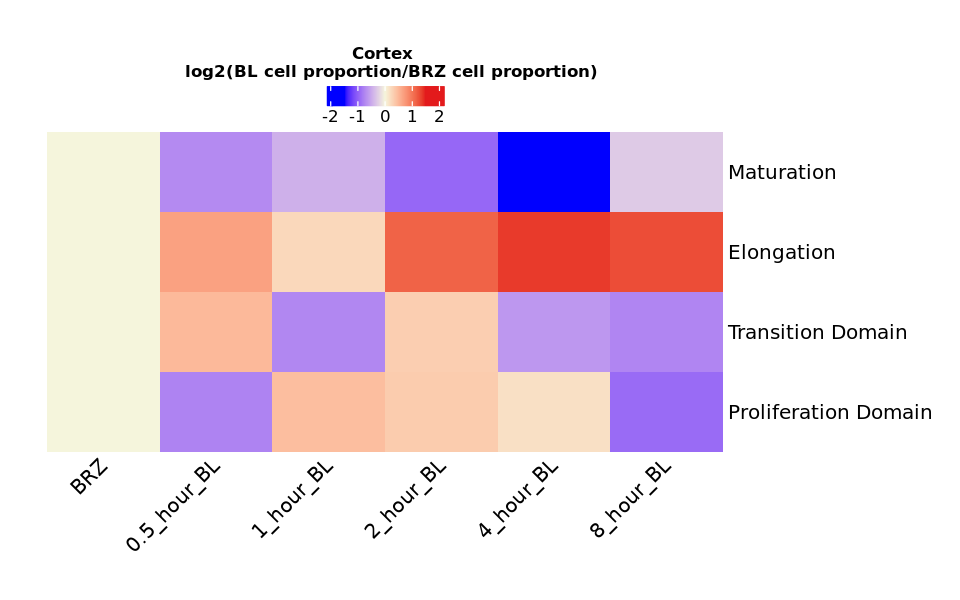

In [10]:
options(repr.plot.width=8, repr.plot.height=5)
# add to hm cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%.0f", int_matrix[i, j]), x, y, gp = gpar(fontsize = 10))})

Cell_hm <- Heatmap(cell_m, name = "Cortex \n  log2(BL cell proportion/BRZ cell proportion)", 
                   heatmap_legend_param = list(title_position="topcenter", 
                                               color_bar = "continuous", 
                                               legend_direction = "horizontal"), 
                   col = colorRamp2(c(-1.5, 0, 1.5), c("blue", "beige", "#e31a1c")), 
                   cluster_rows = F, 
                   cluster_columns = F, 
                   use_raster= FALSE, 
                   column_names_rot = 45,
                   show_column_names = TRUE, show_row_names = TRUE, show_row_dend = TRUE, show_column_dend = TRUE,
                   clustering_distance_rows = "pearson", clustering_distance_columns = "pearson",
                 row_names_gp = gpar(fontsize = 12)) 


draw(Cell_hm, padding = unit(c(10, 10, 10, 10), "mm"), heatmap_legend_side = "top")

In [11]:
pdf("./output/BL_time_course_cortex_cell_abundance.pdf", width = 8, height = 5)


# padding - bottom, left, top, right
draw(Cell_hm, padding = unit(c(10, 20, 10, 10), "mm"), heatmap_legend_side = "top")

dev.off()

png 
  2